# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
Based Convolutional AE, 64x64x3

## 0. Setting

### Goole Drive Connecting

In [ ]:
pwd

'C:\\Users\\hyojj\\멋사 AI SCHOOL\\FINAL'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd '/content/drive/MyDrive/Code Lion/Final'

In [ ]:
# !ls

### Library Call

In [ ]:
# pip install tensorflow

In [ ]:
# pip install tensorflow_addons

In [ ]:
# pip install opencv-python

In [ ]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.model_selection import train_test_split

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [ ]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 64
imgC = 64
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/content/drive/MyDrive/Code Lion/Final/data'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    # 개선점
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# New Sample Image Preprocessing
def New_image_preprocessing(file_name):
  smp = img_read(file_name)
  smp = cv2.resize(smp, (imgR,imgC), cv2.INTER_LINEAR)
  smp = adjust_gamma(smp, 0.8)
  smp = smp/255.0
  return smp

# Load All img from folder
def load_img_folder():
    wfiles = sorted(glob(f'{root_dir}/*.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# -------------Image EDA & Visualization ------------- #

# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# ------------- Model Function ------------- #
def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

# ------------- Recommendation System ------------- #
def Fashion_coordination(top10_result, fashion_df):
  result_df = []
  for item in top10_result:
    ele_df = pd.DataFrame(columns=fashion_df.columns)
    for col in fashion_df.columns:
      ele = fashion_df[fashion_df[col] == item]
      ele_df = pd.concat([ele_df,ele])
    result_df.append(ele_df)
  return result_df

## 1. Data Load

In [ ]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (33170, 64, 64, 3)
label_set.shape : 33170


In [ ]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 215.1971)

In [ ]:
# Label Information
type(label_set), label_set[:4]

(list,
 ['Item-Image\\0928015_B.jpg',
  'Item-Image\\0928015_F.jpg',
  'Item-Image\\0929029_B.jpg',
  'Item-Image\\0929029_F.jpg'])

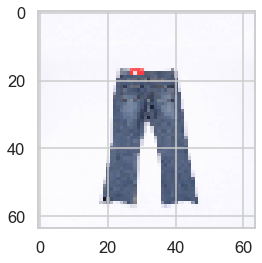

In [ ]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

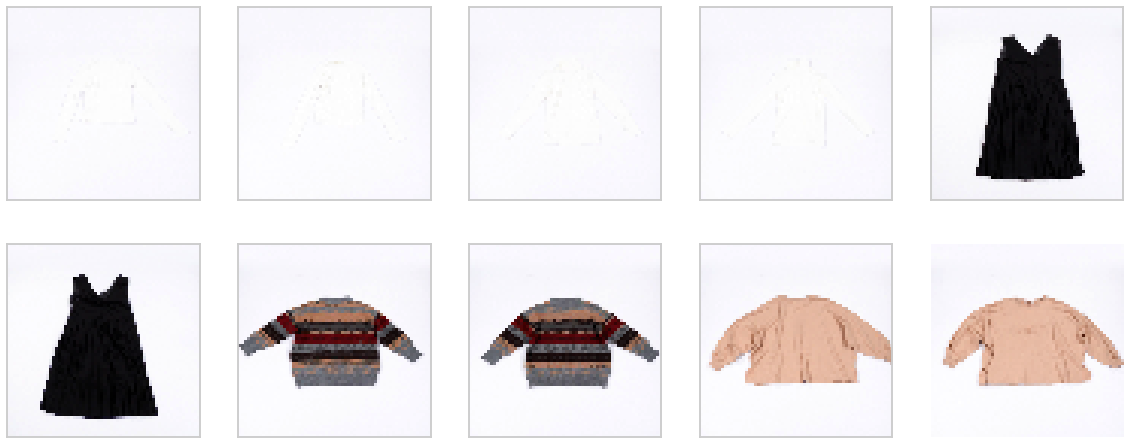

In [ ]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [ ]:
# Data Normalization
img_scaled = img_set.astype("float32")/255
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (33170, 64, 64, 3) 215.19705884027044
Scaled Image Format : (33170, 64, 64, 3) 0.84390664


In [ ]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(26536, 64, 64, 3) 26536
(6634, 64, 64, 3) 6634


## 3. Convolutional Autoencoder Modeling

### Encoder

In [ ]:
# Encoder Part Modeling
tf.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

L1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)
L3 = Conv2D(16, (3, 3), activation='relu', padding='same')(L2)
L4 = MaxPooling2D((2, 2))(L3)
L5 = Conv2D(8, (3, 3), activation='relu', padding='same')(L4)
L6 = MaxPooling2D((2, 2))(L5)
L7 = Conv2D(8, (3, 3), activation='relu', padding='same')(L6)
L8 = MaxPooling2D((2, 2))(L7)

encoder_output = L8

In [ ]:
# Encoder Summary()
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160  

In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Decoder

In [ ]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

L9 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L10 = UpSampling2D((2, 2))(L9)
L11 = Conv2D(8, (3, 3), activation='relu', padding='same')(L10)
L12 = UpSampling2D((2, 2))(L11)
L13 = Conv2D(16, (3, 3), activation='relu', padding='same')(L12)
L14 = UpSampling2D((2, 2))(L13)
L15 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(L14)
L16 = UpSampling2D((2, 2))(L15)
L17 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L16)

decoder_output = L17

In [ ]:
# Decoder Summary()
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168

In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### AutoEncoder (Encoder + Decoder)

In [ ]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = keras.Model(init_input, connect_output)

In [ ]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [ ]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 8)           7264      
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         7843      
                                                                 
Total params: 15,107
Trainable params: 15,107
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 64

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|                                                                               0/100 ETA: ?s,  …

Epoch 1/100


0/394                                                                                                        E…

Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.2218
Epoch 1: val_loss improved from 0.22794 to 0.22376, saving model to Training-checkpoint\cp-0001-0.22.ckpt
394/394 [==============================] - 320s 813ms/step - loss: 0.2218 - val_loss: 0.2238
Epoch 2/100


0/394                                                                                                        E…

Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.2214
Epoch 2: val_loss improved from 0.22376 to 0.22325, saving model to Training-checkpoint\cp-0002-0.22.ckpt
394/394 [==============================] - 282s 716ms/step - loss: 0.2214 - val_loss: 0.2233
Epoch 3/100


0/394                                                                                                        E…

Epoch 3/100
394/394 [==============================] - ETA: 0s - loss: 0.2210
Epoch 3: val_loss did not improve from 0.22325
394/394 [==============================] - 289s 734ms/step - loss: 0.2210 - val_loss: 0.2233
Epoch 4/100


0/394                                                                                                        E…

Epoch 4/100
394/394 [==============================] - ETA: 0s - loss: 0.2207
Epoch 4: val_loss improved from 0.22325 to 0.22261, saving model to Training-checkpoint\cp-0004-0.22.ckpt
394/394 [==============================] - 272s 691ms/step - loss: 0.2207 - val_loss: 0.2226
Epoch 5/100


0/394                                                                                                        E…

Epoch 5/100
394/394 [==============================] - ETA: 0s - loss: 0.2203
Epoch 5: val_loss improved from 0.22261 to 0.22238, saving model to Training-checkpoint\cp-0005-0.22.ckpt
394/394 [==============================] - 295s 748ms/step - loss: 0.2203 - val_loss: 0.2224
Epoch 6/100


0/394                                                                                                        E…

Epoch 6/100
394/394 [==============================] - ETA: 0s - loss: 0.2201
Epoch 6: val_loss improved from 0.22238 to 0.22208, saving model to Training-checkpoint\cp-0006-0.22.ckpt
394/394 [==============================] - 292s 740ms/step - loss: 0.2201 - val_loss: 0.2221
Epoch 7/100


0/394                                                                                                        E…

Epoch 7/100
394/394 [==============================] - ETA: 0s - loss: 0.2197
Epoch 7: val_loss improved from 0.22208 to 0.22160, saving model to Training-checkpoint\cp-0007-0.22.ckpt
394/394 [==============================] - 272s 690ms/step - loss: 0.2197 - val_loss: 0.2216
Epoch 8/100


0/394                                                                                                        E…

Epoch 8/100
394/394 [==============================] - ETA: 0s - loss: 0.2195
Epoch 8: val_loss improved from 0.22160 to 0.22151, saving model to Training-checkpoint\cp-0008-0.22.ckpt
394/394 [==============================] - 252s 640ms/step - loss: 0.2195 - val_loss: 0.2215
Epoch 9/100


0/394                                                                                                        E…

Epoch 9/100
394/394 [==============================] - ETA: 0s - loss: 0.2192
Epoch 9: val_loss improved from 0.22151 to 0.22106, saving model to Training-checkpoint\cp-0009-0.22.ckpt
394/394 [==============================] - 259s 658ms/step - loss: 0.2192 - val_loss: 0.2211
Epoch 10/100


0/394                                                                                                        E…

Epoch 10/100
394/394 [==============================] - ETA: 0s - loss: 0.2192
Epoch 10: val_loss did not improve from 0.22106
394/394 [==============================] - 268s 681ms/step - loss: 0.2192 - val_loss: 0.2211
Epoch 11/100


0/394                                                                                                        E…

Epoch 11/100
394/394 [==============================] - ETA: 0s - loss: 0.2189
Epoch 11: val_loss improved from 0.22106 to 0.22074, saving model to Training-checkpoint\cp-0011-0.22.ckpt
394/394 [==============================] - 266s 675ms/step - loss: 0.2189 - val_loss: 0.2207
Epoch 12/100


0/394                                                                                                        E…

Epoch 12/100
394/394 [==============================] - ETA: 0s - loss: 0.2187
Epoch 12: val_loss did not improve from 0.22074
394/394 [==============================] - 271s 689ms/step - loss: 0.2187 - val_loss: 0.2210
Epoch 13/100


0/394                                                                                                        E…

Epoch 13/100
394/394 [==============================] - ETA: 0s - loss: 0.2185
Epoch 13: val_loss improved from 0.22074 to 0.22035, saving model to Training-checkpoint\cp-0013-0.22.ckpt
394/394 [==============================] - 275s 698ms/step - loss: 0.2185 - val_loss: 0.2204
Epoch 14/100


0/394                                                                                                        E…

Epoch 14/100
394/394 [==============================] - ETA: 0s - loss: 0.2184
Epoch 14: val_loss did not improve from 0.22035
394/394 [==============================] - 256s 651ms/step - loss: 0.2184 - val_loss: 0.2205
Epoch 15/100


0/394                                                                                                        E…

Epoch 15/100
394/394 [==============================] - ETA: 0s - loss: 0.2183
Epoch 15: val_loss improved from 0.22035 to 0.22033, saving model to Training-checkpoint\cp-0015-0.22.ckpt
394/394 [==============================] - 254s 645ms/step - loss: 0.2183 - val_loss: 0.2203
Epoch 16/100


0/394                                                                                                        E…

Epoch 16/100
394/394 [==============================] - ETA: 0s - loss: 0.2182
Epoch 16: val_loss did not improve from 0.22033
394/394 [==============================] - 289s 735ms/step - loss: 0.2182 - val_loss: 0.2212
Epoch 17/100


0/394                                                                                                        E…

Epoch 17/100
394/394 [==============================] - ETA: 0s - loss: 0.2180
Epoch 17: val_loss improved from 0.22033 to 0.22021, saving model to Training-checkpoint\cp-0017-0.22.ckpt
394/394 [==============================] - 292s 740ms/step - loss: 0.2180 - val_loss: 0.2202
Epoch 18/100


0/394                                                                                                        E…

Epoch 18/100
394/394 [==============================] - ETA: 0s - loss: 0.2179
Epoch 18: val_loss improved from 0.22021 to 0.22010, saving model to Training-checkpoint\cp-0018-0.22.ckpt
394/394 [==============================] - 283s 718ms/step - loss: 0.2179 - val_loss: 0.2201
Epoch 19/100


0/394                                                                                                        E…

Epoch 19/100
394/394 [==============================] - ETA: 0s - loss: 0.2178
Epoch 19: val_loss improved from 0.22010 to 0.22004, saving model to Training-checkpoint\cp-0019-0.22.ckpt
394/394 [==============================] - 304s 772ms/step - loss: 0.2178 - val_loss: 0.2200
Epoch 20/100


0/394                                                                                                        E…

Epoch 20/100
394/394 [==============================] - ETA: 0s - loss: 0.2178
Epoch 20: val_loss improved from 0.22004 to 0.21979, saving model to Training-checkpoint\cp-0020-0.22.ckpt
394/394 [==============================] - 280s 710ms/step - loss: 0.2178 - val_loss: 0.2198
Epoch 21/100


0/394                                                                                                        E…

Epoch 21/100
394/394 [==============================] - ETA: 0s - loss: 0.2176
Epoch 21: val_loss improved from 0.21979 to 0.21962, saving model to Training-checkpoint\cp-0021-0.22.ckpt
394/394 [==============================] - 198s 502ms/step - loss: 0.2176 - val_loss: 0.2196
Epoch 22/100


0/394                                                                                                        E…

Epoch 22/100
394/394 [==============================] - ETA: 0s - loss: 0.2175
Epoch 22: val_loss improved from 0.21962 to 0.21949, saving model to Training-checkpoint\cp-0022-0.22.ckpt
394/394 [==============================] - 193s 490ms/step - loss: 0.2175 - val_loss: 0.2195
Epoch 23/100


0/394                                                                                                        E…

Epoch 23/100
394/394 [==============================] - ETA: 0s - loss: 0.2175
Epoch 23: val_loss did not improve from 0.21949
394/394 [==============================] - 235s 597ms/step - loss: 0.2175 - val_loss: 0.2198
Epoch 24/100


0/394                                                                                                        E…

Epoch 24/100
394/394 [==============================] - ETA: 0s - loss: 0.2174
Epoch 24: val_loss did not improve from 0.21949
394/394 [==============================] - 196s 497ms/step - loss: 0.2174 - val_loss: 0.2195
Epoch 25/100


0/394                                                                                                        E…

Epoch 25/100
394/394 [==============================] - ETA: 0s - loss: 0.2173
Epoch 25: val_loss improved from 0.21949 to 0.21931, saving model to Training-checkpoint\cp-0025-0.22.ckpt
394/394 [==============================] - 214s 542ms/step - loss: 0.2173 - val_loss: 0.2193
Epoch 26/100


0/394                                                                                                        E…

Epoch 26/100
394/394 [==============================] - ETA: 0s - loss: 0.2172
Epoch 26: val_loss did not improve from 0.21931
394/394 [==============================] - 205s 520ms/step - loss: 0.2172 - val_loss: 0.2194
Epoch 27/100


0/394                                                                                                        E…

Epoch 27/100
394/394 [==============================] - ETA: 0s - loss: 0.2171
Epoch 27: val_loss did not improve from 0.21931
394/394 [==============================] - 205s 521ms/step - loss: 0.2171 - val_loss: 0.2194
Epoch 28/100


0/394                                                                                                        E…

Epoch 28/100
394/394 [==============================] - ETA: 0s - loss: 0.2171
Epoch 28: val_loss improved from 0.21931 to 0.21920, saving model to Training-checkpoint\cp-0028-0.22.ckpt
394/394 [==============================] - 189s 478ms/step - loss: 0.2171 - val_loss: 0.2192
Epoch 29/100


0/394                                                                                                        E…

Epoch 29/100
394/394 [==============================] - ETA: 0s - loss: 0.2171
Epoch 29: val_loss did not improve from 0.21920
394/394 [==============================] - 185s 470ms/step - loss: 0.2171 - val_loss: 0.2195
Epoch 30/100


0/394                                                                                                        E…

Epoch 30/100
394/394 [==============================] - ETA: 0s - loss: 0.2169
Epoch 30: val_loss improved from 0.21920 to 0.21913, saving model to Training-checkpoint\cp-0030-0.22.ckpt
394/394 [==============================] - 186s 472ms/step - loss: 0.2169 - val_loss: 0.2191
Epoch 31/100


0/394                                                                                                        E…

Epoch 31/100
394/394 [==============================] - ETA: 0s - loss: 0.2169
Epoch 31: val_loss improved from 0.21913 to 0.21890, saving model to Training-checkpoint\cp-0031-0.22.ckpt
394/394 [==============================] - 187s 473ms/step - loss: 0.2169 - val_loss: 0.2189
Epoch 32/100


0/394                                                                                                        E…

Epoch 32/100
394/394 [==============================] - ETA: 0s - loss: 0.2168
Epoch 32: val_loss did not improve from 0.21890
394/394 [==============================] - 185s 471ms/step - loss: 0.2168 - val_loss: 0.2189
Epoch 33/100


0/394                                                                                                        E…

Epoch 33/100
394/394 [==============================] - ETA: 0s - loss: 0.2168
Epoch 33: val_loss did not improve from 0.21890
394/394 [==============================] - 185s 471ms/step - loss: 0.2168 - val_loss: 0.2200
Epoch 34/100


0/394                                                                                                        E…

Epoch 34/100
394/394 [==============================] - ETA: 0s - loss: 0.2167
Epoch 34: val_loss did not improve from 0.21890
394/394 [==============================] - 196s 496ms/step - loss: 0.2167 - val_loss: 0.2199
Epoch 35/100


0/394                                                                                                        E…

Epoch 35/100
394/394 [==============================] - ETA: 0s - loss: 0.2166
Epoch 35: val_loss did not improve from 0.21890
394/394 [==============================] - 186s 472ms/step - loss: 0.2166 - val_loss: 0.2189
Epoch 36/100


0/394                                                                                                        E…

Epoch 36/100
394/394 [==============================] - ETA: 0s - loss: 0.2166
Epoch 36: val_loss improved from 0.21890 to 0.21847, saving model to Training-checkpoint\cp-0036-0.22.ckpt
394/394 [==============================] - 186s 472ms/step - loss: 0.2166 - val_loss: 0.2185
Epoch 37/100


0/394                                                                                                        E…

Epoch 37/100
394/394 [==============================] - ETA: 0s - loss: 0.2165
Epoch 37: val_loss did not improve from 0.21847
394/394 [==============================] - 186s 472ms/step - loss: 0.2165 - val_loss: 0.2185
Epoch 38/100


0/394                                                                                                        E…

Epoch 38/100
394/394 [==============================] - ETA: 0s - loss: 0.2164
Epoch 38: val_loss improved from 0.21847 to 0.21832, saving model to Training-checkpoint\cp-0038-0.22.ckpt
394/394 [==============================] - 185s 469ms/step - loss: 0.2164 - val_loss: 0.2183
Epoch 39/100


0/394                                                                                                        E…

Epoch 39/100
394/394 [==============================] - ETA: 0s - loss: 0.2165
Epoch 39: val_loss did not improve from 0.21832
394/394 [==============================] - 188s 476ms/step - loss: 0.2165 - val_loss: 0.2184
Epoch 40/100


0/394                                                                                                        E…

Epoch 40/100
394/394 [==============================] - ETA: 0s - loss: 0.2163
Epoch 40: val_loss did not improve from 0.21832
394/394 [==============================] - 186s 472ms/step - loss: 0.2163 - val_loss: 0.2186
Epoch 41/100


0/394                                                                                                        E…

Epoch 41/100
394/394 [==============================] - ETA: 0s - loss: 0.2163
Epoch 41: val_loss did not improve from 0.21832
394/394 [==============================] - 186s 473ms/step - loss: 0.2163 - val_loss: 0.2184
Epoch 42/100


0/394                                                                                                        E…

Epoch 42/100
394/394 [==============================] - ETA: 0s - loss: 0.2162
Epoch 42: val_loss improved from 0.21832 to 0.21811, saving model to Training-checkpoint\cp-0042-0.22.ckpt
394/394 [==============================] - 299s 758ms/step - loss: 0.2162 - val_loss: 0.2181
Epoch 43/100


0/394                                                                                                        E…

Epoch 43/100
394/394 [==============================] - ETA: 0s - loss: 0.2161
Epoch 43: val_loss did not improve from 0.21811
394/394 [==============================] - 297s 754ms/step - loss: 0.2161 - val_loss: 0.2185
Epoch 44/100


0/394                                                                                                        E…

Epoch 44/100
394/394 [==============================] - ETA: 0s - loss: 0.2161
Epoch 44: val_loss did not improve from 0.21811
394/394 [==============================] - 266s 675ms/step - loss: 0.2161 - val_loss: 0.2186
Epoch 45/100


0/394                                                                                                        E…

Epoch 45/100
394/394 [==============================] - ETA: 0s - loss: 0.2160
Epoch 45: val_loss did not improve from 0.21811
394/394 [==============================] - 297s 755ms/step - loss: 0.2160 - val_loss: 0.2185
Epoch 46/100


0/394                                                                                                        E…

Epoch 46/100
394/394 [==============================] - ETA: 0s - loss: 0.2160
Epoch 46: val_loss did not improve from 0.21811
394/394 [==============================] - 305s 773ms/step - loss: 0.2160 - val_loss: 0.2188
Epoch 47/100


0/394                                                                                                        E…

Epoch 47/100
394/394 [==============================] - ETA: 0s - loss: 0.2159
Epoch 47: val_loss did not improve from 0.21811
394/394 [==============================] - 347s 880ms/step - loss: 0.2159 - val_loss: 0.2182
Epoch 48/100


0/394                                                                                                        E…

Epoch 48/100
394/394 [==============================] - ETA: 0s - loss: 0.2160
Epoch 48: val_loss improved from 0.21811 to 0.21799, saving model to Training-checkpoint\cp-0048-0.22.ckpt
394/394 [==============================] - 333s 846ms/step - loss: 0.2160 - val_loss: 0.2180
Epoch 49/100


0/394                                                                                                        E…

Epoch 49/100
394/394 [==============================] - ETA: 0s - loss: 0.2158
Epoch 49: val_loss did not improve from 0.21799
394/394 [==============================] - 361s 915ms/step - loss: 0.2158 - val_loss: 0.2181
Epoch 50/100


0/394                                                                                                        E…

Epoch 50/100
394/394 [==============================] - ETA: 0s - loss: 0.2157
Epoch 50: val_loss improved from 0.21799 to 0.21778, saving model to Training-checkpoint\cp-0050-0.22.ckpt
394/394 [==============================] - 340s 862ms/step - loss: 0.2157 - val_loss: 0.2178
Epoch 51/100


0/394                                                                                                        E…

Epoch 51/100
394/394 [==============================] - ETA: 0s - loss: 0.2157
Epoch 51: val_loss did not improve from 0.21778
394/394 [==============================] - 348s 885ms/step - loss: 0.2157 - val_loss: 0.2179
Epoch 52/100


0/394                                                                                                        E…

Epoch 52/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 52: val_loss did not improve from 0.21778
394/394 [==============================] - 340s 864ms/step - loss: 0.2156 - val_loss: 0.2178
Epoch 53/100


0/394                                                                                                        E…

Epoch 53/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 53: val_loss improved from 0.21778 to 0.21757, saving model to Training-checkpoint\cp-0053-0.22.ckpt
394/394 [==============================] - 270s 686ms/step - loss: 0.2156 - val_loss: 0.2176
Epoch 54/100


0/394                                                                                                        E…

Epoch 54/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 54: val_loss improved from 0.21757 to 0.21757, saving model to Training-checkpoint\cp-0054-0.22.ckpt
394/394 [==============================] - 213s 540ms/step - loss: 0.2156 - val_loss: 0.2176
Epoch 55/100


0/394                                                                                                        E…

Epoch 55/100
394/394 [==============================] - ETA: 0s - loss: 0.2155
Epoch 55: val_loss did not improve from 0.21757
394/394 [==============================] - 207s 526ms/step - loss: 0.2155 - val_loss: 0.2176
Epoch 56/100


0/394                                                                                                        E…

Epoch 56/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 56: val_loss did not improve from 0.21757
394/394 [==============================] - 205s 519ms/step - loss: 0.2156 - val_loss: 0.2178
Epoch 57/100


0/394                                                                                                        E…

Epoch 57/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 57: val_loss did not improve from 0.21757
394/394 [==============================] - 215s 545ms/step - loss: 0.2154 - val_loss: 0.2176
Epoch 58/100


0/394                                                                                                        E…

Epoch 58/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 58: val_loss did not improve from 0.21757
394/394 [==============================] - 300s 761ms/step - loss: 0.2154 - val_loss: 0.2178
Epoch 59/100


0/394                                                                                                        E…

Epoch 59/100
394/394 [==============================] - ETA: 0s - loss: 0.2153
Epoch 59: val_loss improved from 0.21757 to 0.21736, saving model to Training-checkpoint\cp-0059-0.22.ckpt
394/394 [==============================] - 332s 844ms/step - loss: 0.2153 - val_loss: 0.2174
Epoch 60/100


0/394                                                                                                        E…

Epoch 60/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 60: val_loss did not improve from 0.21736
394/394 [==============================] - 354s 899ms/step - loss: 0.2154 - val_loss: 0.2176
Epoch 61/100


0/394                                                                                                        E…

Epoch 61/100
394/394 [==============================] - ETA: 0s - loss: 0.2152
Epoch 61: val_loss did not improve from 0.21736
394/394 [==============================] - 342s 869ms/step - loss: 0.2152 - val_loss: 0.2174
Epoch 62/100


0/394                                                                                                        E…

Epoch 62/100
394/394 [==============================] - ETA: 0s - loss: 0.2153
Epoch 62: val_loss improved from 0.21736 to 0.21733, saving model to Training-checkpoint\cp-0062-0.22.ckpt
394/394 [==============================] - 423s 1s/step - loss: 0.2153 - val_loss: 0.2173
Epoch 63/100


0/394                                                                                                        E…

Epoch 63/100
394/394 [==============================] - ETA: 0s - loss: 0.2152
Epoch 63: val_loss did not improve from 0.21733
394/394 [==============================] - 434s 1s/step - loss: 0.2152 - val_loss: 0.2180
Epoch 64/100


0/394                                                                                                        E…

Epoch 64/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 64: val_loss improved from 0.21733 to 0.21716, saving model to Training-checkpoint\cp-0064-0.22.ckpt
394/394 [==============================] - 501s 1s/step - loss: 0.2151 - val_loss: 0.2172
Epoch 65/100


0/394                                                                                                        E…

Epoch 65/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 65: val_loss improved from 0.21716 to 0.21712, saving model to Training-checkpoint\cp-0065-0.22.ckpt
394/394 [==============================] - 408s 1s/step - loss: 0.2151 - val_loss: 0.2171
Epoch 66/100


0/394                                                                                                        E…

Epoch 66/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 66: val_loss improved from 0.21712 to 0.21706, saving model to Training-checkpoint\cp-0066-0.22.ckpt
394/394 [==============================] - 367s 931ms/step - loss: 0.2151 - val_loss: 0.2171
Epoch 67/100


0/394                                                                                                        E…

Epoch 67/100
394/394 [==============================] - ETA: 0s - loss: 0.2150
Epoch 67: val_loss did not improve from 0.21706
394/394 [==============================] - 281s 713ms/step - loss: 0.2150 - val_loss: 0.2177
Epoch 68/100


0/394                                                                                                        E…

Epoch 68/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 68: val_loss improved from 0.21706 to 0.21701, saving model to Training-checkpoint\cp-0068-0.22.ckpt
394/394 [==============================] - 246s 625ms/step - loss: 0.2151 - val_loss: 0.2170
Epoch 69/100


0/394                                                                                                        E…

Epoch 69/100
394/394 [==============================] - ETA: 0s - loss: 0.2149
Epoch 69: val_loss did not improve from 0.21701
394/394 [==============================] - 241s 611ms/step - loss: 0.2149 - val_loss: 0.2171
Epoch 70/100


0/394                                                                                                        E…

Epoch 70/100
394/394 [==============================] - ETA: 0s - loss: 0.2150
Epoch 70: val_loss did not improve from 0.21701
394/394 [==============================] - 249s 631ms/step - loss: 0.2150 - val_loss: 0.2177
Epoch 71/100


0/394                                                                                                        E…

Epoch 71/100
394/394 [==============================] - ETA: 0s - loss: 0.2148
Epoch 71: val_loss improved from 0.21701 to 0.21699, saving model to Training-checkpoint\cp-0071-0.22.ckpt
394/394 [==============================] - 359s 912ms/step - loss: 0.2148 - val_loss: 0.2170
Epoch 72/100


0/394                                                                                                        E…

Epoch 72/100
394/394 [==============================] - ETA: 0s - loss: 0.2148
Epoch 72: val_loss improved from 0.21699 to 0.21697, saving model to Training-checkpoint\cp-0072-0.22.ckpt
394/394 [==============================] - 347s 882ms/step - loss: 0.2148 - val_loss: 0.2170
Epoch 73/100


0/394                                                                                                        E…

Epoch 73/100
394/394 [==============================] - ETA: 0s - loss: 0.2149
Epoch 73: val_loss improved from 0.21697 to 0.21691, saving model to Training-checkpoint\cp-0073-0.22.ckpt
394/394 [==============================] - 412s 1s/step - loss: 0.2149 - val_loss: 0.2169
Epoch 74/100


0/394                                                                                                        E…

Epoch 74/100
394/394 [==============================] - ETA: 0s - loss: 0.2148
Epoch 74: val_loss did not improve from 0.21691
394/394 [==============================] - 390s 992ms/step - loss: 0.2148 - val_loss: 0.2174
Epoch 75/100


0/394                                                                                                        E…

Epoch 75/100
394/394 [==============================] - ETA: 0s - loss: 0.2148
Epoch 75: val_loss improved from 0.21691 to 0.21683, saving model to Training-checkpoint\cp-0075-0.22.ckpt
394/394 [==============================] - 366s 930ms/step - loss: 0.2148 - val_loss: 0.2168
Epoch 76/100


0/394                                                                                                        E…

Epoch 76/100
394/394 [==============================] - ETA: 0s - loss: 0.2147
Epoch 76: val_loss did not improve from 0.21683
394/394 [==============================] - 381s 968ms/step - loss: 0.2147 - val_loss: 0.2170
Epoch 77/100


0/394                                                                                                        E…

Epoch 77/100
394/394 [==============================] - ETA: 0s - loss: 0.2147
Epoch 77: val_loss improved from 0.21683 to 0.21673, saving model to Training-checkpoint\cp-0077-0.22.ckpt
394/394 [==============================] - 451s 1s/step - loss: 0.2147 - val_loss: 0.2167
Epoch 78/100


0/394                                                                                                        E…

Epoch 78/100
394/394 [==============================] - ETA: 0s - loss: 0.2147
Epoch 78: val_loss did not improve from 0.21673
394/394 [==============================] - 545s 1s/step - loss: 0.2147 - val_loss: 0.2170
Epoch 79/100


0/394                                                                                                        E…

Epoch 79/100
394/394 [==============================] - ETA: 0s - loss: 0.2146
Epoch 79: val_loss did not improve from 0.21673
394/394 [==============================] - 443s 1s/step - loss: 0.2146 - val_loss: 0.2168
Epoch 80/100


0/394                                                                                                        E…

Epoch 80/100
394/394 [==============================] - ETA: 0s - loss: 0.2147
Epoch 80: val_loss did not improve from 0.21673
394/394 [==============================] - 255s 648ms/step - loss: 0.2147 - val_loss: 0.2168
Epoch 81/100


0/394                                                                                                        E…

Epoch 81/100
394/394 [==============================] - ETA: 0s - loss: 0.2145
Epoch 81: val_loss improved from 0.21673 to 0.21666, saving model to Training-checkpoint\cp-0081-0.22.ckpt
394/394 [==============================] - 235s 596ms/step - loss: 0.2145 - val_loss: 0.2167
Epoch 82/100


0/394                                                                                                        E…

Epoch 82/100
394/394 [==============================] - ETA: 0s - loss: 0.2146
Epoch 82: val_loss did not improve from 0.21666
394/394 [==============================] - 233s 592ms/step - loss: 0.2146 - val_loss: 0.2168
Epoch 83/100


0/394                                                                                                        E…

Epoch 83/100
394/394 [==============================] - ETA: 0s - loss: 0.2145
Epoch 83: val_loss did not improve from 0.21666
394/394 [==============================] - 258s 654ms/step - loss: 0.2145 - val_loss: 0.2168
Epoch 84/100


0/394                                                                                                        E…

Epoch 84/100
394/394 [==============================] - ETA: 0s - loss: 0.2146
Epoch 84: val_loss did not improve from 0.21666
394/394 [==============================] - 377s 956ms/step - loss: 0.2146 - val_loss: 0.2167
Epoch 85/100


0/394                                                                                                        E…

Epoch 85/100
394/394 [==============================] - ETA: 0s - loss: 0.2145
Epoch 85: val_loss did not improve from 0.21666
394/394 [==============================] - 429s 1s/step - loss: 0.2145 - val_loss: 0.2167
Epoch 86/100


0/394                                                                                                        E…

Epoch 86/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 86: val_loss improved from 0.21666 to 0.21649, saving model to Training-checkpoint\cp-0086-0.22.ckpt
394/394 [==============================] - 567s 1s/step - loss: 0.2144 - val_loss: 0.2165
Epoch 87/100


0/394                                                                                                        E…

Epoch 87/100
394/394 [==============================] - ETA: 0s - loss: 0.2145
Epoch 87: val_loss did not improve from 0.21649
394/394 [==============================] - 499s 1s/step - loss: 0.2145 - val_loss: 0.2168
Epoch 88/100


0/394                                                                                                        E…

Epoch 88/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 88: val_loss did not improve from 0.21649
394/394 [==============================] - 472s 1s/step - loss: 0.2144 - val_loss: 0.2166
Epoch 89/100


0/394                                                                                                        E…

Epoch 89/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 89: val_loss improved from 0.21649 to 0.21639, saving model to Training-checkpoint\cp-0089-0.22.ckpt
394/394 [==============================] - 451s 1s/step - loss: 0.2144 - val_loss: 0.2164
Epoch 90/100


0/394                                                                                                        E…

Epoch 90/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 90: val_loss did not improve from 0.21639
394/394 [==============================] - 414s 1s/step - loss: 0.2144 - val_loss: 0.2166
Epoch 91/100


0/394                                                                                                        E…

Epoch 91/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 91: val_loss improved from 0.21639 to 0.21631, saving model to Training-checkpoint\cp-0091-0.22.ckpt
394/394 [==============================] - 380s 965ms/step - loss: 0.2144 - val_loss: 0.2163
Epoch 92/100


0/394                                                                                                        E…

Epoch 92/100
394/394 [==============================] - ETA: 0s - loss: 0.2143
Epoch 92: val_loss did not improve from 0.21631
394/394 [==============================] - 287s 728ms/step - loss: 0.2143 - val_loss: 0.2166
Epoch 93/100


0/394                                                                                                        E…

Epoch 93/100
394/394 [==============================] - ETA: 0s - loss: 0.2144
Epoch 93: val_loss did not improve from 0.21631
394/394 [==============================] - 202s 512ms/step - loss: 0.2144 - val_loss: 0.2163
Epoch 94/100


0/394                                                                                                        E…

Epoch 94/100
394/394 [==============================] - ETA: 0s - loss: 0.2143
Epoch 94: val_loss did not improve from 0.21631
394/394 [==============================] - 199s 504ms/step - loss: 0.2143 - val_loss: 0.2166
Epoch 95/100


0/394                                                                                                        E…

Epoch 95/100
394/394 [==============================] - ETA: 0s - loss: 0.2143
Epoch 95: val_loss did not improve from 0.21631
394/394 [==============================] - 198s 501ms/step - loss: 0.2143 - val_loss: 0.2163
Epoch 96/100


0/394                                                                                                        E…

Epoch 96/100
394/394 [==============================] - ETA: 0s - loss: 0.2143
Epoch 96: val_loss did not improve from 0.21631
394/394 [==============================] - 196s 499ms/step - loss: 0.2143 - val_loss: 0.2166
Epoch 97/100


0/394                                                                                                        E…

Epoch 97/100
394/394 [==============================] - ETA: 0s - loss: 0.2142
Epoch 97: val_loss did not improve from 0.21631
394/394 [==============================] - 196s 498ms/step - loss: 0.2142 - val_loss: 0.2166
Epoch 98/100


0/394                                                                                                        E…

Epoch 98/100
394/394 [==============================] - ETA: 0s - loss: 0.2142
Epoch 98: val_loss improved from 0.21631 to 0.21630, saving model to Training-checkpoint\cp-0098-0.22.ckpt
394/394 [==============================] - 197s 500ms/step - loss: 0.2142 - val_loss: 0.2163
Epoch 99/100


0/394                                                                                                        E…

Epoch 99/100
394/394 [==============================] - ETA: 0s - loss: 0.2142
Epoch 99: val_loss improved from 0.21630 to 0.21625, saving model to Training-checkpoint\cp-0099-0.22.ckpt
394/394 [==============================] - 222s 565ms/step - loss: 0.2142 - val_loss: 0.2162
Epoch 100/100


0/394                                                                                                        E…

Epoch 100/100
394/394 [==============================] - ETA: 0s - loss: 0.2142
Epoch 100: val_loss did not improve from 0.21625
394/394 [==============================] - 235s 597ms/step - loss: 0.2142 - val_loss: 0.2165


In [ ]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 8:02:39


In [ ]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.head()

,loss,val_loss
0,0.221827,0.223763
1,0.221384,0.223253
2,0.221020,0.223333
3,0.220654,0.222609
4,0.220324,0.222375


In [ ]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
98,0.214196,0.216246


In [ ]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0810/')

# Decoder Part Save
decoder.save('model_save/Decoder_0810/')

# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0810/')

INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0810/')
decoder = keras.models.load_model('model_save/Decoder_0810/')
model = keras.models.load_model('model_save/ConvAE_0810/')

## 4. Performance Evaluation

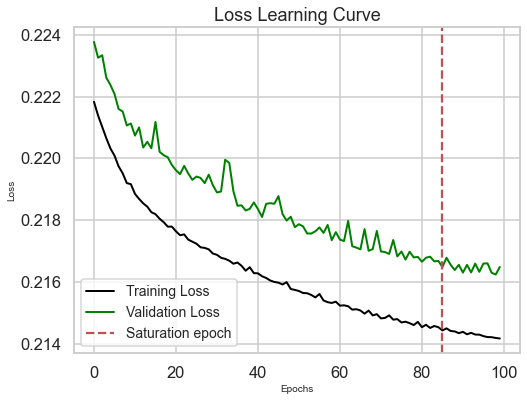

In [ ]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

<Figure size 432x288 with 0 Axes>

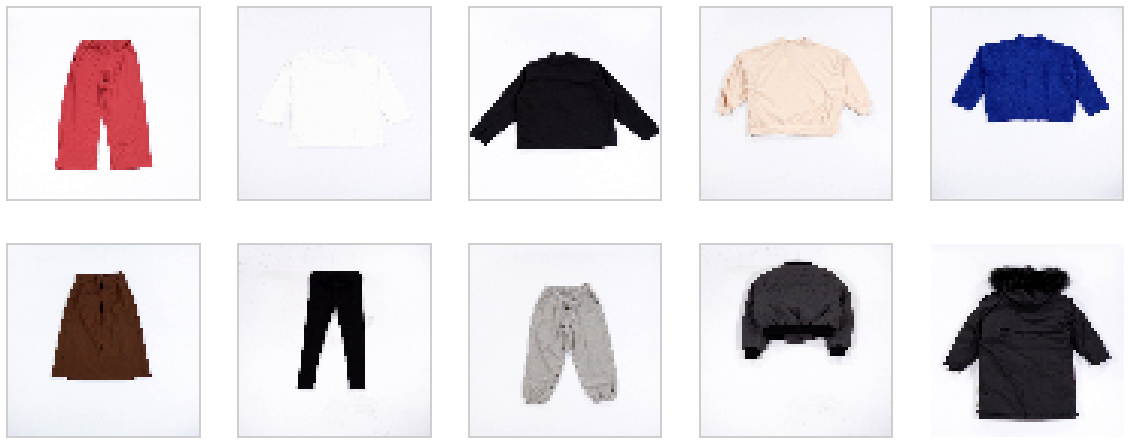

In [ ]:
# Test Image Samples
_ = plot_images(2,5,X_test)

<Figure size 432x288 with 0 Axes>

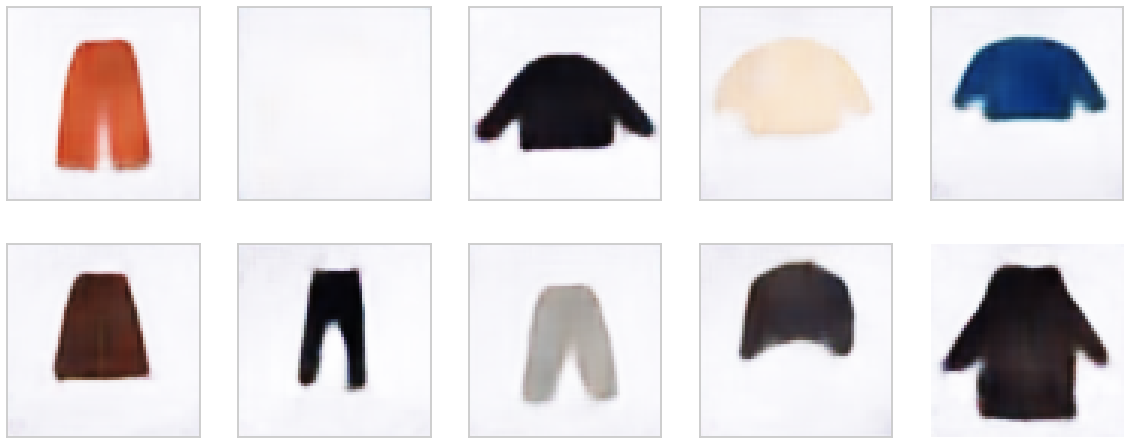

In [ ]:
# Prediction Image Samples
_ = plot_images(2,5,X_pred)

In [ ]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

208/208 [==============================] - 17s 79ms/step - loss: 0.2159
test loss : 0.2159


In [ ]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

208/208 [==============================] - 17s 79ms/step


((6634, 64, 64, 3), 0.8466)

In [ ]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(6634, list)

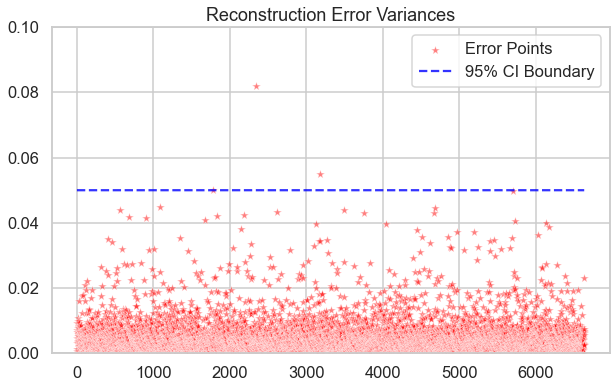

In [ ]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [ ]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

1037/1037 [==============================] - 32s 30ms/step


((33170, 4, 4, 8), numpy.ndarray)

In [ ]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((33170, 8), numpy.ndarray)

In [ ]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (33170, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,1.752176,0.0,2.928560,0.151501,0.301445,0.0,1.659367,1.663814,Item-Image\0928015_B.jpg
1,1.725444,0.0,2.963389,0.116877,0.254775,0.0,1.595392,1.644688,Item-Image\0928015_F.jpg
2,1.757339,0.0,2.920527,0.154265,0.303064,0.0,1.665625,1.662964,Item-Image\0929029_B.jpg
3,1.755971,0.0,2.926385,0.142468,0.287524,0.0,1.647761,1.658970,Item-Image\0929029_F.jpg
4,2.658271,0.0,2.954451,3.370543,4.708439,0.0,3.320060,4.021251,Item-Image\1008001_B.jpg


In [ ]:
# Latent Feature DataFrame export to csv
df.to_csv('latent_feature_0812.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [ ]:
# Latent Feature DataFrame load
df = pd.read_csv('latent_feature_0812.csv')
print(df.shape)
df.head()

(33170, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,1.752176,0.0,2.928560,0.151501,0.301445,0.0,1.659367,1.663814,Item-Image\0928015_B.jpg
1,1.725444,0.0,2.963389,0.116877,0.254775,0.0,1.595392,1.644688,Item-Image\0928015_F.jpg
2,1.757339,0.0,2.920526,0.154265,0.303064,0.0,1.665625,1.662964,Item-Image\0929029_B.jpg
3,1.755971,0.0,2.926385,0.142468,0.287524,0.0,1.647761,1.658970,Item-Image\0929029_F.jpg
4,2.658271,0.0,2.954451,3.370543,4.708439,0.0,3.320060,4.021251,Item-Image\1008001_B.jpg


In [ ]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(33170, 8) (33170,)


### Cosine Similarity

In [ ]:
# Cosine Similarity Computation
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(data.astype('float32'), data.astype('float32'))
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

cosine_matrix.shape : (33170, 33170)


array([[1.0000001 , 0.99973214, 0.9999959 , 0.9999887 ],
       [0.99973214, 1.0000001 , 0.9996696 , 0.9998038 ],
       [0.9999959 , 0.9996696 , 0.9999998 , 0.9999794 ],
       [0.9999887 , 0.9998038 , 0.9999794 , 0.9999999 ]], dtype=float32)

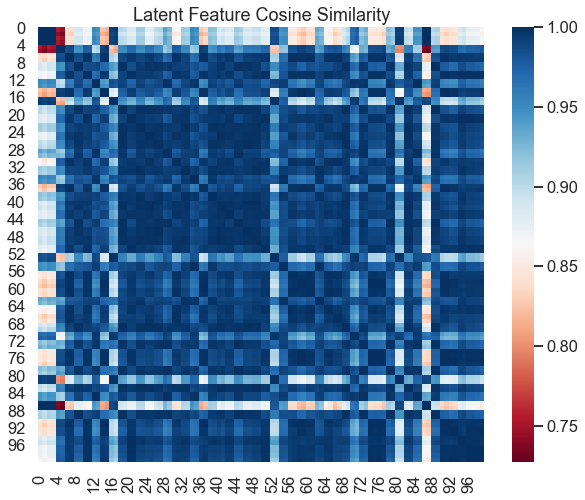

In [ ]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

sample_idx : 15795


In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 33170)


In [ ]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [ ]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (33170, 1)


,sample
0,0.757127
1,0.744203
2,0.758108
3,0.754369


In [ ]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
print('top10_idx_cosine :',top10_idx_cosine)
print(label[top10_idx_cosine].values)

top10_idx_cosine : Int64Index([15795, 26229, 15794, 21454, 27516, 26228, 4241, 15544, 1834, 4223], dtype='int64')
['Item-Image\\1111077_F.jpg' 'Item-Image\\1130030_F.jpg'
 'Item-Image\\1111077_B.jpg' 'Item-Image\\1119024_B.jpg'
 'Item-Image\\1202033_B.jpg' 'Item-Image\\1130030_B.jpg'
 'Item-Image\\1019450_F.jpg' 'Item-Image\\1110405_B.jpg'
 'Item-Image\\1014225_B.jpg' 'Item-Image\\1019441_F.jpg']


Item-Image\1111077_F.jpg


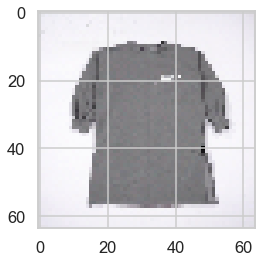

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

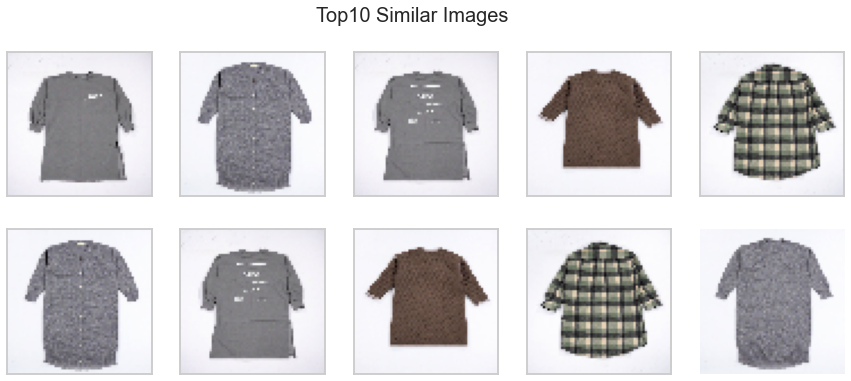

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [ ]:
# Euclidean Distance Calculation
from sklearn.metrics.pairwise import euclidean_distances 

ec_matrix = 1 / euclidean_distances(data.astype('float32'), data.astype('float32'))
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

In [ ]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 33170)


In [ ]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (33170, 1)


,sample
0,0.189599
1,0.186613
2,0.189800
3,0.188916


In [ ]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([15795, 26229, 15794, 26228, 25767, 12816, 12817, 11839, 8154,
            23165],
           dtype='int64')
['Item-Image\\1111077_F.jpg' 'Item-Image\\1130030_F.jpg'
 'Item-Image\\1111077_B.jpg' 'Item-Image\\1130030_B.jpg'
 'Item-Image\\1127104_F.jpg' 'Item-Image\\1105384_B.jpg'
 'Item-Image\\1105384_F.jpg' 'Item-Image\\1104152_F.jpg'
 'Item-Image\\1028014_B.jpg' 'Item-Image\\1123182_F.jpg']


Item-Image\1111077_F.jpg


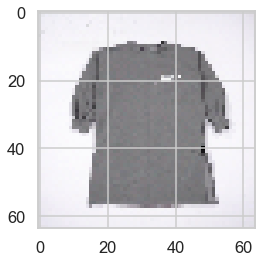

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

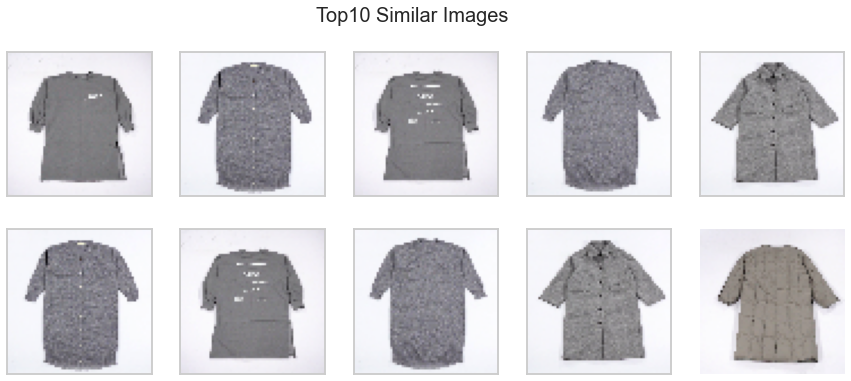

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [ ]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.astype('float32').to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

In [ ]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

In [ ]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

In [ ]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

Item-Image\1111077_F.jpg


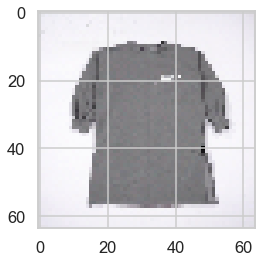

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)

## 7. Fashion Coordination Recommendation

### Fashion Coordination Dataframe Design

In [ ]:
# fashion coordination dataframe
fashion_df = pd.read_csv('fashion data/uni_wearing.csv')
print('fashion_df.shape :',fashion_df.shape)
fashion_df.head()

fashion_df.shape : (18040, 6)


,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013.0,1008011,NaN,1008012.0,NaN
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449.0,1029157,NaN,1029107.0,NaN
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442.0,1029411,NaN,1029109.0,NaN
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434.0,1029073,NaN,1029141.0,NaN
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431.0,1029255,NaN,1029142.0,NaN


In [ ]:
# fashion dataframe Information
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wearing    18040 non-null  object 
 1   hat        32 non-null     float64
 2   main_top   18040 non-null  int64  
 3   inner_top  2838 non-null   float64
 4   bottom     16224 non-null  float64
 5   shoes      125 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 845.8+ KB


In [ ]:
# fashion dataframe 
print(fashion_df.isna().sum())

wearing          0
hat          18008
main_top         0
inner_top    15202
bottom        1816
shoes        17915
dtype: int64


In [ ]:
# fashion dataframe Missing Value Imputation
fashion_df.fillna(0,inplace=True)
print('Remain Missing Value :',fashion_df.isna().sum().sum())

Remain Missing Value : 0


In [ ]:
# fashion data preprocessing
fashion_df.iloc[:,1:] = fashion_df.iloc[:,1:].astype(int)
fashion_df.head()

,wearing,hat,main_top,inner_top,bottom,shoes
0,1008_1008_720_A_A001_A001_000.jpg,1008013,1008011,0,1008012,0
1,1030_1030_720_A_A002_232_223_222_A002_000.jpg,1029449,1029157,0,1029107,0
2,1030_1030_720_A_A003_232_220_222_A003_000.jpg,1029442,1029411,0,1029109,0
3,1030_1030_720_B_B002_232_221_223_B002_000.jpg,1029434,1029073,0,1029141,0
4,1030_1030_720_B_B003_232_227_223_B003_000.jpg,1029431,1029255,0,1029142,0


### Match the coordination

In [ ]:
# top10 label by cosine similarity
top10_label_cosine

array(['1019386_B.jpg', '1116482_B.jpg', '1209174_F.jpg', '1116482_F.jpg',
       '1209174_B.jpg', '1127316_F.jpg', '1127316_B.jpg', '1102128_F.jpg',
       '1019386_F.jpg', '1126177_F.jpg'], dtype=object)

In [ ]:
# top10 label preprocessing
top10_result_cosine = list(map(lambda x : int(x[:7]), top10_label_cosine))
top10_result_cosine

[1019386,
 1116482,
 1209174,
 1116482,
 1209174,
 1127316,
 1127316,
 1102128,
 1019386,
 1126177]

In [ ]:
# top10 Recommendation Result
recomm_df = Fashion_coordination(top10_result_cosine, fashion_df)
print('recomm_df :',len(recomm_df),'DataFrame')
for i in range(len(recomm_df)):
  print(f"{i+1} item's coordination cases :",recomm_df[i].shape[0])

recomm_df : 10 DataFrame
1 item's coordination cases : 9
2 item's coordination cases : 8
3 item's coordination cases : 4
4 item's coordination cases : 8
5 item's coordination cases : 4
6 item's coordination cases : 12
7 item's coordination cases : 12
8 item's coordination cases : 10
9 item's coordination cases : 9
10 item's coordination cases : 1


In [ ]:
# First Similar Item Coordination Info
recomm_df[0].head()

,wearing,hat,main_top,inner_top,bottom,shoes
2225,1020_1020_720_A_A022_103_101_A022_000.jpg,0,1019415,0,1019386,0
2230,1020_1020_720_A_A028_108_101_A028_000.jpg,0,1019504,0,1019386,0
2444,1020_1020_720_C_C051_101_C051_000.jpg,0,1019495,0,1019386,0
2446,1020_1020_720_C_C053_088_101_C053_000.jpg,0,1019081,0,1019386,0
2448,1020_1020_720_C_C055_095_101_C055_000.jpg,0,1019257,0,1019386,0


### Recommendation Service Output Result

In [ ]:
pwd

'/content/drive/MyDrive/Code Lion/Final'

In [ ]:
root_dir

'/content/drive/MyDrive/Code Lion/Final/data'

In [ ]:
count = 0
fig = plt.figure()
fig, ax = plt.subplots(2,5,figsize=(5*3,2*3))
plt.suptitle('Fashion Best Fit Recommendatation!!')
for i in range(2):
  for j in range(5):
    axis = ax[i,j]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    fashion_img_name = recomm_df[count].iloc[0,0]
    try:
      img = img_read(root_dir + '/' + fashion_img_name)
      axis.imshow(img)
      plt.axis('off')
    except:
      pass
plt.show()

1
2
3
4
5
6
7
8
9
10
